# Purpose of this notebook:
The purpose of this notebook is to document example code used to construct an mne epoch array structure, from the PTSA related structures.

### Helpful References:

#### Creating MNE objects from arbitrary data arrays:
https://martinos.org/mne/dev/auto_examples/io/plot_objects_from_arrays.html
#### MNE EpochsArray documentation: 
https://martinos.org/mne/stable/generated/mne.EpochsArray.html
#### MNE Reading and Writing Raw Files:
https://martinos.org/mne/stable/auto_examples/io/plot_read_and_write_raw_data.html#sphx-glr-auto-examples-io-plot-read-and-write-raw-data-py





In [28]:
#Import tools
import mne
import numpy as np
import cPickle as pk
import os
from os import mkdir
from glob import glob
from ptsa.data.readers import BaseEventReader
from ptsa.data.readers.TalReader import TalReader
from ptsa.data.readers import EEGReader
from ptsa.data.filters import MonopolarToBipolarMapper
from ptsa.data.filters import ButterworthFilter
from ptsa.data.events import Events
from ptsa.data.readers.IndexReader import JsonIndexReader

reader = JsonIndexReader('/protocols/r1.json')


class CommitMNEDemo(object):
    
    def __init__(self, subject_id, exp, win_st = 0.0, win_fin = 1.6, 
                 buffer_time=1.0, samplerate=500.0):
        
        self.s = subject_id
        self.task = exp
        self.win_st = win_st
        self.win_fin = win_fin
        self.buffer_time = buffer_time
        self.samplerate = samplerate
        self.set_electrodes()
        self.set_events_encoding()
        
    def set_electrodes(self):
        
        sub = self.s
        
        # Get tal struct
        tal_path = '/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_monopol.mat'
        tal_struct = TalReader(filename=tal_path, struct_name='talStruct').read()
        self.tal_struct = tal_struct
        tal_path_bipol = '/data/eeg/'+sub+'/tal/'+sub+'_talLocs_database_bipol.mat'
        tal_reader = TalReader(filename=tal_path_bipol)
        
        # Set as attributes
        self.mp_tal = tal_struct
        self.bp_tal = tal_reader.read()
        self.mp = tal_reader.get_monopolar_channels()
        self.bp = tal_reader.get_bipolar_pairs()
        
    def set_events_encoding(self):

        sub = self.s

        #Get available montages
        montages = reader.montages(subject=sub, experiment=self.task)

        #Just use the first montage for the task to avoid confusion
        montage=montages[0]
        sessions = reader.sessions(subject=sub, experiment=self.task, montage=montage)

        #Get events
        evfiles = list(reader.aggregate_values('task_events', subject=sub, experiment=self.task, montage=montage))

        evs = np.array([])
        for ef in evfiles:
            base_e_reader = BaseEventReader(filename=ef, eliminate_events_with_no_eeg=True)
            base_events = base_e_reader.read()
            if len(evs) == 0:
                evs = base_events[base_events.type=='WORD']
            else:
                evs = np.concatenate((evs, base_events[base_events.type=='WORD']), axis=0)
        evs = Events(evs)
        self.evs = evs

    def set_mne_structure_encoding(self):

        sub = self.s

        #Get EEGs
        eeg_reader = EEGReader(events=self.evs, channels=self.mp,
                              start_time=self.win_st, end_time=self.win_fin, buffer_time=self.buffer_time)
        eegs = eeg_reader.read()

        #Filter out line noise
        if sub[0:2] == 'FR':
            freq_range = [48., 52.]
        else:
            freq_range = [58., 62.]
        b_filter = ButterworthFilter(time_series=eegs, freq_range=freq_range, filt_type='stop', order=4)
        eegs_filtered = b_filter.filter()
        eegs_filtered = eegs_filtered.resampled(self.samplerate) #resample if needed

        #Create MNE dataset
        n_channels = eegs_filtered.shape[0]
        ch_names = list(self.mp_tal['tagName'])
        info = mne.create_info(ch_names, self.samplerate, ch_types='eeg')

        #Reorganize data for MNE format
        data = eegs_filtered.transpose('events', 'channels', 'time')
        
        #Create events array for MNE
        mne_evs = np.empty([data['events'].shape[0], 3]).astype(int)
        mne_evs[:, 0] = np.arange(data['events'].shape[0])
        mne_evs[:, 1] = data['time'].shape[0]
        mne_evs[:, 2] = list(self.evs.recalled)

        event_id = dict(recalled=1, not_recalled=0)
        tmin=0.0

        arr = mne.EpochsArray(np.array(data), info, mne_evs, tmin, event_id)
        arr.set_eeg_reference(ref_channels=None) #Set to average reference
        arr.apply_proj()

        self.arr = arr
        self.session = self.evs.session

        # ONLY SET THESE AS ATTRIBUTES TO FACILITATE UNDERSTANDING WHAT THEY ARE!!!
        self.data = data
        self.info = info
        self.ch_names = ch_names
        return

# Demo Example From intracranial dataset, plot PSD

In [29]:
self = CommitMNEDemo(subject_id='R1111M', exp= 'FR1')

In [30]:
self.set_mne_structure_encoding()

1020 matching events found
0 projection items activated
0 bad epochs dropped
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but hasn't been applied yet. Use the .apply_proj() method function to apply projections.
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


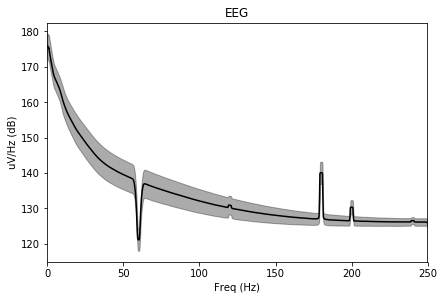

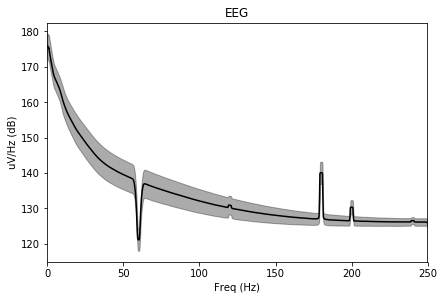

In [38]:
self.arr.plot_psd()

# Load in raw scalp data into mne, Show example plots

In [40]:
raw = mne.io.read_raw_edf('/data/eeg/scalp/ltp/ltpFR2/LTP376/session_1/eeg/LTP376_session_1.bdf', eog=['EXG{}'.format(x) for x in range(1,9)],
                          montage='biosemi128', preload=False)

Extracting edf Parameters from /data/eeg/scalp/ltp/ltpFR2/LTP376/session_1/eeg/LTP376_session_1.bdf...
Setting channel info structure...
Creating Raw.info structure...
Ready.


Effective window size : 1.000 (s)


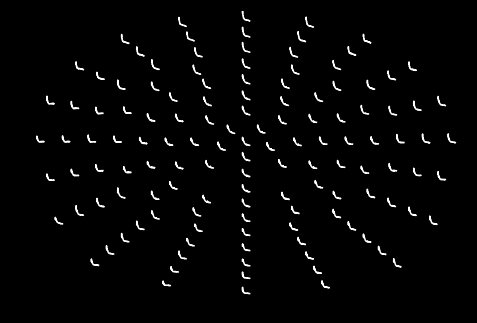

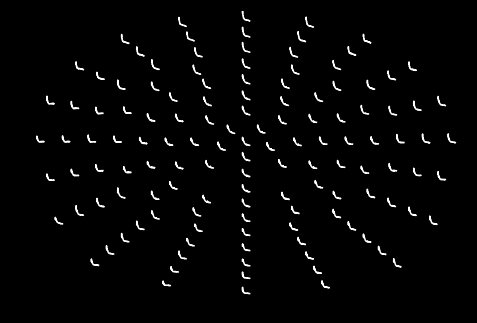

In [51]:
raw.plot_psd_topo(tmax=1000.)

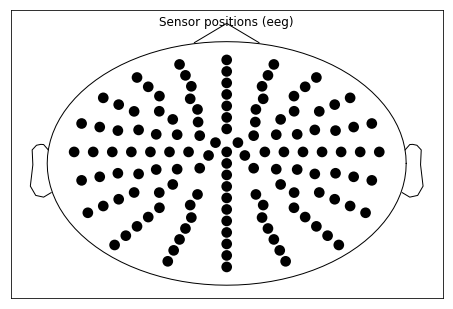

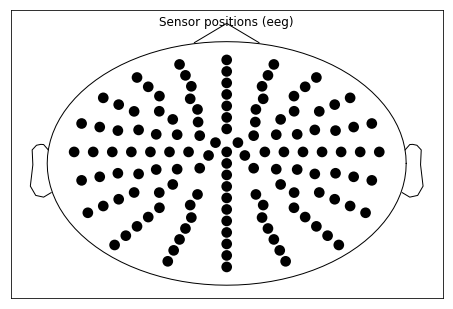

In [52]:
raw.plot_sensors()

In [58]:
events = mne.find_events(raw)

Removing orphaned offset at the beginning of the file.
5223 events found
Events id: [8]


In [59]:
epochs = mne.Epochs(raw, events)

5223 matching events found
0 projection items activated


Loading data for 5223 events and 1435 original time points ...


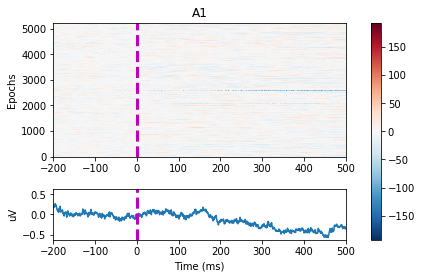

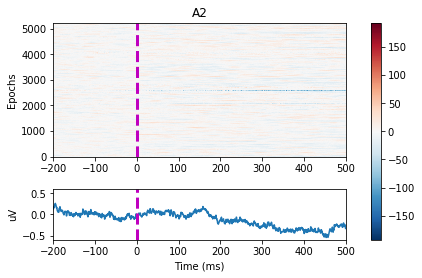

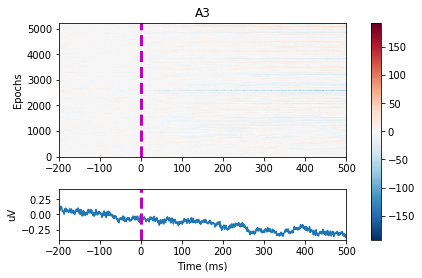

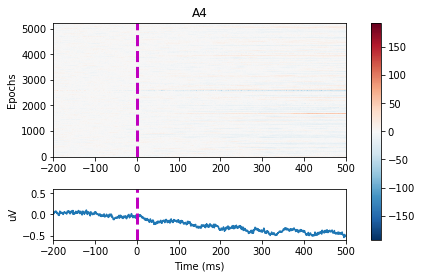

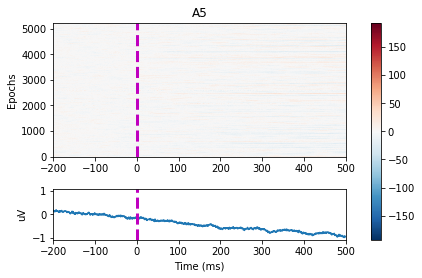

In [64]:
epochs.plot_image()

Loading data for 5223 events and 1435 original time points ...
0 bad epochs dropped


/home2/loganf/anaconda3/envs/ptsa_fresh/lib/python2.7/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


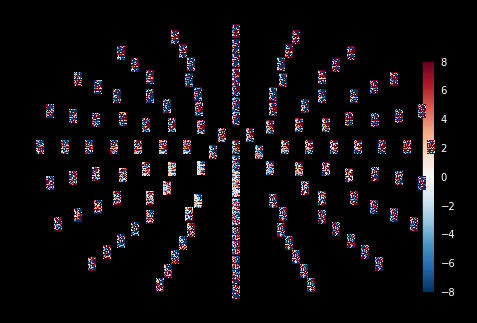

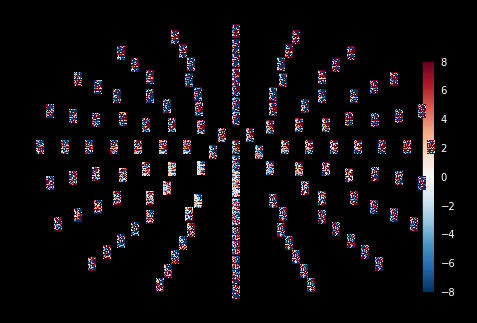

In [60]:
epochs.plot_topo_image()

Loading data for 1 events and 1435 original time points ...


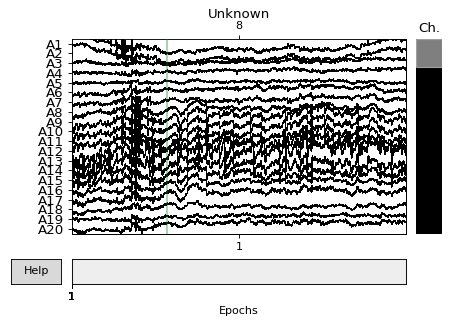

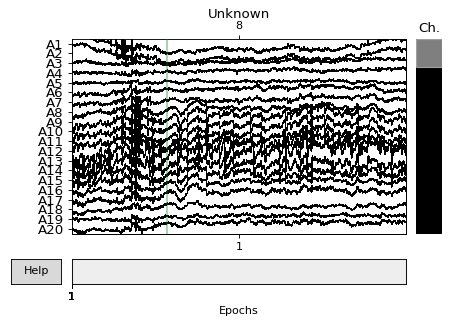

In [66]:
epochs[0].plot()